# Olfactory Bulb Glomerular Segmentation & Trace Extraction (CalmAn)

**Goal:** Motion-correct two-photon imaging movies, automatically segment glomeruli (ROIs), extract fluorescence traces, and export both figures and tidy data for downstream analysis.

**What you get at the end:**

1.  **Summary Figure A** — Correlation image and max projection with cleaned ROI contours overlaid.
2.  **Summary Figure B** — Per-ROI panels (ROI footprint next to its fluorescence trace), saved as a multi-page PDF.
3.  **DataFrames** — In-memory pandas DataFrames containing all ROI information and fluorescence traces.
4.  **Saved HDF5 Output** — A single, structured HDF5 file containing dF/F traces, Z-score traces, raw fluorescence traces, and all pixel/weight information for kept ROIs.

> **Tip:** Run cells from top to bottom. Every step has quality-control checks and human-readable logging.

### 0) Environment & Dependencies

This notebook requires a standard scientific Python environment with the CaImAn library installed.

*   Requires **CaImAn** and a typical scientific Python stack (`numpy`, `pandas`, `scipy`, `matplotlib`, `scikit-image`).
*   To save the final output, `h5py` and `tables` are also required. You can install them with `pip install h5py tables`.
*   Tested with Python 3.10–3.11 and CaImAn ≥ 1.9.
*   If you run into GPU/cluster setup issues, you can switch to CPU-only processing by setting `n_processes=1` in the CNMF step (Step 5).

In [1]:
# --- Imports & Basic Setup ---
import os
import sys
import warnings
import json
import logging
import h5py
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display, Image as IPyImage
import imageio.v2 as imageio

# --- CalmAn imports (installed separately) ---
try:
    import caiman as cm
    from caiman.motion_correction import MotionCorrect
    from caiman.source_extraction.cnmf import params as caiman_params
    from caiman.source_extraction import cnmf as cnmf_mod
    from caiman.utils.visualization import plot_contours
    from caiman.cluster import setup_cluster, stop_server
except ImportError as e:
    raise ImportError(
        "CaImAn not found. Please install CaImAn in your environment.\n"
        "See: https://github.com/flatironinstitute/CaImAn"
    ) from e

from skimage.measure import regionprops
import scipy.ndimage

# --- Matplotlib defaults ---
plt.rcParams["figure.dpi"] = 120

# --- Suppress repetitive warnings ---
# This warning is common in CaImAn analysis and can be safely ignored.
warnings.filterwarnings(
    "ignore",
    message=".*nperseg = 256 is greater than input length.*",
    category=UserWarning,
    module="scipy.signal._spectral_py"
)
# This suppresses a deprecation warning from CaImAn's dependency on an older package.
warnings.filterwarnings("ignore", category=UserWarning, module='caiman')


/Users/mosse/miniforge3/envs/caiman/lib/python3.11/site-packages/caiman/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### 1) Configure Paths & Parameters

**You must edit the `movie_path` variable in the cell below.** All other parameters have sensible defaults, but you may need to adjust them based on your specific data.

*   **Paths**:
    *   `movie_path`: The full path to your input TIFF movie file.
    *   `out_dir`: The directory where all outputs (figures, data files) will be saved. By default, it's created alongside the `raw` movie folder.
*   **Acquisition Info**:
    *   `fr_manual`: Your movie's frame rate (in Hz). The script will try to read this from the TIFF metadata, but uses this value as a fallback.
    *   `decay_time`: The decay time of your calcium indicator (in seconds). This is a crucial parameter for CNMF.
    *   `dxy`: The pixel size (in μm/pixel) as a `(y, x)` tuple.
*   **Analysis Heuristics**:
    *   `w10`: An estimate of the diameter of a typical ROI (glomerulus) in pixels. This single value is used to derive many other parameters for motion correction and component detection, simplifying the configuration process.
*   **Algorithm Parameters**:
    *   The script automatically sets reasonable starting values for motion correction (`mc_opts`), CNMF initialization (`K`, `gSig`), evaluation (`min_SNR`, `rval_thr`), and component cleaning (`threshold_percentile`, `min_pixels`, etc.) based on the `w10` heuristic. Advanced users can modify these directly in the configuration cell.

In [2]:
# --- Configuration ---

# --- YOU MUST EDIT THIS --- 
# Input movie path
movie_path = Path("/Volumes/MossLab/ImagingData/20250822/e2/raw/20250822_sid174_e2_00004.tif")
# --- END EDIT --- 

# Output directory (created if missing)
# This places outputs in a new folder alongside the movie's parent directory.
raw_dir = movie_path.parent
session_dir = raw_dir.parent
out_dir = session_dir / "outputs"
out_dir.mkdir(exist_ok=True, parents=True)

# Acquisition / field-of-view info
fr_manual = 24.0      # Fallback frame rate, replaced if metadata is available
decay_time = 0.1      # Typical transient length (s) for GCaMP
dxy = (2, 2)          # (μm per pixel) in y, x

# General size heuristics (used for patch size and ROI filtering)
# w10 should be approx the diameter of a mid-size glomerulus in pixels
w10 = 20              # <-- adjust as needed; initial guess

# --- DERIVED PARAMETERS (ADVANCED) ---

# Motion correction parameters (NoRMCorre)
mc_opts = dict(
    strides=(w10, w10),
    overlaps=(w10 // 2, w10 // 2),
    max_shifts=(w10 // 2, w10 // 2),
    max_deviation_rigid=w10 // 4,
    pw_rigid=True, # Use piecewise-rigid correction
)

# CNMF Initialization
K = 3                 # Components per patch (heuristic)
gSig = np.array([w10 // 2, w10 // 2]) # Expected half-width of ROIs
gSiz = 2 * gSig + 1   # Full width of ROIs
ssub = 1 #max(1, w10 // 10) # Spatial downsampling factor
tsub = 1 #2                 # Temporal downsampling factor

# CNMF Evaluation thresholds
min_SNR = 1.0         # Signal-to-noise threshold for accepting a component
rval_thr = 0.3        # Spatial correlation threshold for accepting a component
merge_thr = 0.95      # Correlation threshold for merging overlapping components

# Cleaning thresholds
threshold_percentile = 15 # (0-100) footprint threshold (percent of component max)
convolution_threshold = 50 # Shape filter: perimeter^2/area > X is discarded
min_pixels = ((w10) ** 2) / 4
max_pixels = ((w10) ** 2) * 6

# Export paths
roi_panels_per_page = 4 # Number of ROI panels per page in the summary PDF
export_hdf5 = out_dir / "caiman_analysis_results.hdf5"
summary_fig_A = out_dir / "summary_corr_max_overlays.png"
summary_fig_B_pdf = out_dir / "roi_panels.pdf"

print("Movie path:", movie_path.resolve())
print("Outputs will be saved under:", out_dir.resolve())

Movie path: /Volumes/MossLab/ImagingData/20250822/e2/raw/20250822_sid174_e2_00004.tif
Outputs will be saved under: /Volumes/MossLab/ImagingData/20250822/e2/outputs


### 2) Utility Functions

This cell contains all the helper functions used in the main pipeline. You don't need to modify anything here. These functions handle tasks like reading metadata, running motion correction, fitting CNMF, cleaning components, and generating figures and data tables.

In [18]:
def get_scanimage_fps(movie_path, default_fr=None):
    """Return ScanImage per-frame rate from FrameData, or default if missing"""
    # Note: Requires tifffile to be installed
    try:
        import tifffile
        with tifffile.TiffFile(movie_path) as tf:
            si_meta = getattr(tf, "scanimage_metadata", None)
            if isinstance(si_meta, dict):
                fd = si_meta.get("FrameData", {})
                fps = fd.get("SI.hRoiManager.scanFrameRate", None)
                if fps is not None:
                    return float(fps)
    except Exception as e:
        print(f"Could not read frame rate from TIFF metadata: {e}")
    return default_fr


def compute_qc_images(movie, q_low=5, q_high=98):
    #Compute max-projection and correlation image (both used for QC/visual
    # Replace NaNs temporarily for max-projection
    movie_no_nan = np.nan_to_num(movie, nan=-np.inf)
    max_proj = np.max(movie_no_nan, axis=0)

    corr_img = cm.local_correlations(movie, swap_dim=False)
    corr_img[np.isnan(corr_img)] = 0

    # Clip for display (percentiles)
    vmax1 = np.percentile(max_proj.ravel(), q_high)
    vmin1 = np.percentile(max_proj.ravel(), q_low)

    vmax2 = np.percentile(corr_img.ravel(), q_high)
    vmin2 = np.percentile(corr_img.ravel(), q_low)

    return (max_proj, (vmin1, vmax1)), (corr_img, (vmin2, vmax2))


def run_motion_correction(movie_path, mc_opts, n_processes=None):
    """Piecewise-rigid motion correction using CaImAn NoRMCorre."""
    logging.info("Loading movie for motion correction: %s", movie_path)
    mc = MotionCorrect(str(movie_path), dview=None, **mc_opts)
    mc.motion_correct(save_movie=True)
    logging.info("Motion correction complete.")
    return mc


def memmap_movie(mmap_file, border_to_0=0):
    """Save memory-mapped version (trim borders if needed) and return movie objects."""
    mc_memmapped_fname = cm.save_memmap(
        mmap_file, base_name="memmap_", order="C", border_to_0=border_to_0,
    )
    Yr, dims, T = cm.load_memmap(mc_memmapped_fname)
    images = np.reshape(Yr.T, [T] + list(dims), order="F")
    return Yr, dims, T, images, mc_memmapped_fname


def build_cnmf_params(movie_path_str, frame_rate, dxy_tuple):
    """Build CaImAn CNMF parameters dictionary from script variables."""
    rf_target = int(w10 + 2)
    stride_target = int(2 * w10 / 3)
    
    opts_dict = {
        # The following parameters must be nested under the 'data' key.
        "data": {
            "fnames": [movie_path_str],
            "fr": float(frame_rate),
            "dxy": tuple(map(float, dxy_tuple)),
        },
      
        "decay_time": decay_time,
        "patch": {
            "rf": rf_target,
            "stride": stride_target,
            "only_init": False,
        },
        "init": {
            "K": int(K),
            "gSig": [int(gSig[0]), int(gSig[1])],
            "gSiz": [int(gSiz[0]), int(gSiz[1])],
            "ssub": 1,
            "tsub": 1,
            "rolling_sum": False,
            "normalize_init": True,
            "center_psf": True,
            "nb": 1,
            "method_init": "greedy_roi",
        },
        "preprocess": {
            "check_nan": True,
        },
        "temporal": {
            "p": 0,  # no deconvolution
        },
        "merging": {
            "do_merge": True,
            "merge_thr": merge_thr,
        },
        "quality": {
            "min_SNR": float(min_SNR),
            "rval_thr": float(rval_thr),
        },
    }
    return caiman_params.CNMFParams(params_dict=opts_dict)


def fit_cnmf(
    images,
    params,
    n_processes=1,
    dview=None,
    prefer_fit_file=True,
    memmap_path=None,
    do_refit=True,
):
    """Fit CNMF and (optionally) refit on a writable copy."""
    info = {"used_fit_file": False, "did_refit": False, "delta_C_rms": None}
    model = cnmf_mod.CNMF(n_processes=n_processes, params=params, dview=dview)

    try:
        if prefer_fit_file and memmap_path is not None:
            model.fit_file(memmap_path)
            info["used_fit_file"] = True
        else:
            model.fit(images)
    except Exception as e:
        print(f"Initial fit failed; retrying with in-memory array. Error: {e}")
        model.fit(images)

    try:
        ncomp_fit = model.estimates.C.shape[0]
    except Exception:
        ncomp_fit = model.estimates.A.shape[1]
    print(f"[CNMF] Components after fit: {ncomp_fit}")

    if do_refit:
        print(f"[CNMF] Attempting refit")
        images2 = np.array(images, dtype=np.float32, order="F", copy=True)
        np.nan_to_num(images2, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
        
        try:
            cnmf_refit = model.refit(images2)
            info["did_refit"] = True
            ncomp_refit = cnmf_refit.estimates.C.shape[0]
            print(f"[CNMF] Components after refit: {ncomp_refit}")
            return cnmf_refit, info
        except Exception as e:
            print(f"Refit Failed: {e}")
            
    return model, info


def clean_components(fit, images, threshold_percentile, min_pixels, max_pixels, convolution_threshold):
    """Clean spatial components using morphological & shape heuristics."""
    d1, d2 = fit.dims
    T = images.shape[0]
    A_sparse = fit.estimates.A
    A_full = A_sparse.toarray().reshape((d1, d2, -1), order="F")
    K = A_full.shape[2]
    movie_2d = images.reshape((T, d1 * d2)).T

    kept_indices, valid_contours = [], []
    large_contours, small_contours, convoluted_contours = [], [], []
    cleaned_A_list, z_traces = [], []

    for k in range(K):
        component = A_full[:, :, k]
        thresh = (threshold_percentile / 100.0) * component.max()
        binary = component > thresh
        labeled, n = scipy.ndimage.label(binary)
        if n == 0: continue
        
        mask = (labeled == (np.argmax(np.bincount(labeled.flat)[1:]) + 1))
        mask = scipy.ndimage.binary_fill_holes(mask)
        area = mask.sum()
        if area == 0: continue

        props = regionprops(mask.astype(int))[0]
        convoluted = (props.perimeter ** 2) / props.area > convolution_threshold
        edge = scipy.ndimage.binary_dilation(mask) ^ mask

        if convoluted:
            convoluted_contours.append(edge)
            continue
        if area > max_pixels:
            large_contours.append(edge)
            continue
        if area < min_pixels:
            small_contours.append(edge)
            continue

        cleaned_component = np.zeros_like(component)
        cleaned_component[mask] = component[mask]
        cleaned_A_flat = cleaned_component.flatten(order="F")
        cleaned_A_list.append(cleaned_A_flat)
        valid_contours.append(edge)
        kept_indices.append(k)

        trace = cleaned_A_flat @ movie_2d
        trace_std = trace.std()
        trace_z = (trace - trace.mean()) / (trace_std if trace_std != 0 else 1)
        z_traces.append(trace_z)

    z_matrix = np.vstack(z_traces) if z_traces else np.empty((0, images.shape[0]))
    logging.info(f"Cleaned components: kept={len(valid_contours)}, small={len(small_contours)}, large={len(large_contours)}, convoluted={len(convoluted_contours)}")
    
    return {
        "cleaned_A_list": cleaned_A_list,
        "valid_contours": valid_contours, "large_contours": large_contours,
        "small_contours": small_contours, "convoluted_contours": convoluted_contours,
        "z_matrix": z_matrix, "kept_indices": kept_indices,
    }

def build_roi_tables_unified(fit, images, fr, clean, percentile_q=8, baseline_win_max=1000):
    """Build all ROI tables in one go, using only valid (kept) ROIs."""
    kept_indices = list(clean.get("kept_indices", []))
    z_matrix = clean.get("z_matrix", np.empty((0, images.shape[0])))
    d1, d2 = fit.dims
    T = int(images.shape[0])
    time_s = np.arange(T) / fr if fr else np.arange(T)
    Yr = images.reshape((T, -1), order="F").T
    A_csr = fit.estimates.A.tocsr()

    # --- Build df_pixels (same as before) ---
    pixel_records = []
    for comp_id in kept_indices:
        col = A_csr[:, comp_id].tocoo()
        if col.nnz == 0: continue
        pix_idx, w_raw = col.row, col.data.astype(float)
        w_norm = w_raw / (w_raw.sum() + 1e-10)
        y, x = (pix_idx % d1).astype(int), (pix_idx // d1).astype(int)
        pixel_records.append(pd.DataFrame({"ROI": comp_id, "pixel_idx": pix_idx, "y": y, "x": x, "weight_raw": w_raw, "weight_norm": w_norm}))
    
    df_pixels = pd.concat(pixel_records, ignore_index=True) if pixel_records else pd.DataFrame(columns=["ROI", "pixel_idx", "y", "x", "weight_raw", "weight_norm"])

    # --- Calculate Traces (same as before) ---
    if kept_indices:
        col_sums = np.array(A_csr[:, kept_indices].sum(axis=0)).ravel() + 1e-10
        Dinv = csr_matrix(np.diag(1.0 / col_sums))
        A_norm_kept = A_csr[:, kept_indices] @ Dinv
        F_weighted = A_norm_kept.T @ Yr
    else:
        F_weighted = np.empty((0, T))
        
    Z = z_matrix if z_matrix.shape[0] == len(kept_indices) and z_matrix.shape[1] == T else np.empty_like(F_weighted)
    
    def rolling_percentile(arr, q=percentile_q, win=None):
        win = win or min(baseline_win_max, 2 * (T // 10) + 1)
        base = pd.DataFrame(arr.T).rolling(win, center=True, min_periods=1).quantile(q/100).to_numpy().T
        return base

    if F_weighted.size:
        F0 = rolling_percentile(F_weighted)
        dFF = (F_weighted - F0) / np.maximum(F0, 1e-6)
    else:
        dFF = np.empty_like(F_weighted)

    # --- THIS IS THE EFFICIENT FIX ---
    # 1. Create a dictionary to hold all trace columns.
    trace_data = {}
    for k, comp_id in enumerate(kept_indices):
        trace_data[f"ROI_{comp_id}_F"] = F_weighted[k, :] if F_weighted.size else np.array([])
        trace_data[f"ROI_{comp_id}_Z"] = Z[k, :] if Z.size else np.array([])
        trace_data[f"ROI_{comp_id}_dFF"] = dFF[k, :] if dFF.size else np.array([])

    # 2. Convert the dictionary to a DataFrame in one step.
    traces_df = pd.DataFrame(trace_data)

    # 3. Prepend the 'time_s' column.
    traces_df.insert(0, 'time_s', time_s)
    df_traces_wide = traces_df
    # --- END FIX ---

    # --- Build df_traces_long (can now use the efficient df_traces_wide) ---
    long_records = []
    for comp_id in kept_indices:
        long_records.append(pd.DataFrame({"time_s": time_s, "ROI": comp_id, "measure": "F", "value": df_traces_wide[f"ROI_{comp_id}_F"]}))
        long_records.append(pd.DataFrame({"time_s": time_s, "ROI": comp_id, "measure": "Z", "value": df_traces_wide[f"ROI_{comp_id}_Z"]}))
        long_records.append(pd.DataFrame({"time_s": time_s, "ROI": comp_id, "measure": "dFF", "value": df_traces_wide[f"ROI_{comp_id}_dFF"]}))

    df_traces_long = pd.concat(long_records, ignore_index=True) if long_records else pd.DataFrame()
    
    return df_pixels, df_traces_wide, df_traces_long

def figure_summary_A(max_proj_tuple, corr_img_tuple, valid_contours, summary_path):
    """Create side-by-side correlation image and max projection with ROI contours."""
    (corr, (cmin, cmax)) = corr_img_tuple
    (mp, (mmin, mmax)) = max_proj_tuple
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(corr, vmin=cmin, vmax=cmax); ax1.set_title("Correlation Image"); ax1.axis("off")
    ax2.imshow(mp, vmin=mmin, vmax=mmax, cmap="gray"); ax2.set_title("Max Projection + ROI Contours"); ax2.axis("off")
    for edge in valid_contours: ax2.contour(edge, linewidths=0.75, colors='w')
    fig.tight_layout()
    fig.savefig(summary_path, dpi=200, bbox_inches="tight"); plt.close(fig)

def figure_panels_from_tables(df_pixels, df_traces_wide, pdf_path, dims, **kwargs):
    """Multi-page PDF showing each ROI footprint and its fluorescence trace."""
    per_page = kwargs.get('per_page', 20)
    preferred_measure = kwargs.get('preferred_measure', ("Z", "dFF", "F"))
    corr_image, odor_on_s, odor_off_s, window_s = [kwargs.get(k) for k in ['corr_image', 'odor_on_s', 'odor_off_s', 'window_s']]
    
    roi_order = sorted(pd.unique(df_pixels["ROI"]))
    if not roi_order: return
    
    d1, d2 = int(dims[0]), int(dims[1])
    time_s = df_traces_wide["time_s"].values
    sel = slice(None) if window_s is None else (time_s >= window_s[0]) & (time_s <= window_s[1])

    def pick_trace_column(roi_id):
        for m in preferred_measure:
            if f"ROI_{roi_id}_{m}" in df_traces_wide.columns: return f"ROI_{roi_id}_{m}", m
        return None, None

    all_traces = [df_traces_wide[pick_trace_column(roi_id)[0]].values[sel] for roi_id in roi_order if pick_trace_column(roi_id)[0]]
    if not all_traces: y_global = (-1,1); 
    else: y_global = (np.nanmin([np.nanmin(t) for t in all_traces]), np.nanmax([np.nanmax(t) for t in all_traces]))

    with PdfPages(pdf_path) as pdf:
        for start in range(0, len(roi_order), per_page):
            end = min(start + per_page, len(roi_order))
            page_rois = roi_order[start:end]
            fig, axes = plt.subplots(len(page_rois), 2, figsize=(8.5, 11), constrained_layout=True)
            if len(page_rois) == 1: axes = np.array([axes])
            
            for row, roi_id in enumerate(page_rois):
                ax_img, ax_tr = axes[row, 0], axes[row, 1]
                sub = df_pixels.loc[df_pixels["ROI"] == roi_id]
                roi_img = np.zeros((d1, d2), dtype=float)
                if not sub.empty: roi_img[sub["y"].astype(int), sub["x"].astype(int)] = sub["weight_norm"]

                if corr_image is not None: ax_img.imshow(corr_image, cmap='gray', vmin=np.percentile(corr_image,1), vmax=np.percentile(corr_image,99))
                else: ax_img.imshow(roi_img, cmap='gray')
                ax_img.contour(roi_img, levels=[0.2 * roi_img.max()], colors='green', linewidths=1.2)
                ax_img.set_title(f"ROI {roi_id}"); ax_img.axis('off')
                
                col, meas = pick_trace_column(roi_id)
                if col is None: ax_tr.text(0.5, 0.5, "No trace"); ax_tr.axis('off')
                else: 
                    ax_tr.plot(time_s[sel], df_traces_wide[col].values[sel], color='black', lw=0.9)
                    ax_tr.set_title(f"ROI {roi_id} {meas}"); ax_tr.set_xlabel("Time (s)"); ax_tr.set_ylabel(meas)
                    ax_tr.set_ylim(*y_global)
                    ax_tr.spines[['top', 'right']].set_visible(False)
                    if odor_on_s and odor_off_s: ax_tr.axvspan(odor_on_s, odor_off_s, color='lightblue', alpha=0.3)
            pdf.savefig(fig); plt.close(fig)

def save_hdf5_output(output_path, df_pixels, F_traces, Z_traces, dFF_traces, kept_indices, metadata_dict):
    """Saves all analysis outputs into a single structured HDF5 file using only h5py."""
    # This version avoids the need for the 'pytables' dependency.
    
    # Use 'w' mode to create or overwrite the file in one go.
    with h5py.File(output_path, 'w') as f:
        
        # --- Save the df_pixels DataFrame manually ---
        # Create a group for the ROI pixel information
        roi_info_group = f.create_group('roi_info')
        # Save each column of the DataFrame as a separate dataset within this group
        for col in df_pixels.columns:
            data = df_pixels[col].values
            # h5py requires strings to be encoded as bytes
            if data.dtype == 'object':
                data = data.astype(str).astype(np.string_)
            roi_info_group.create_dataset(col, data=data)

        # --- Save trace data as datasets ---
        traces_group = f.create_group('traces')
        traces_group.create_dataset('raw_F', data=F_traces)
        traces_group.create_dataset('z_score', data=Z_traces)
        traces_group.create_dataset('dFF', data=dFF_traces)
        
        # --- Save kept_indices ---
        f.create_dataset('kept_indices', data=np.array(kept_indices))

        # --- Save metadata as HDF5 attributes ---
        # Storing metadata this way makes the file self-describing.
        meta_group = f.create_group('metadata')
        for key, val in metadata_dict.items():
            try:
                # Convert complex types like dicts/lists to strings to store as attributes
                if isinstance(val, (dict, list, tuple)):
                    meta_group.attrs[key] = str(val)
                else:
                    meta_group.attrs[key] = val
            except TypeError:
                 meta_group.attrs[key] = str(val) # Fallback for any other unsupported types

### 3) Load & Pre-QC

We load the raw movie and compute two quick quality-control images:
1.  **Max Projection**: The maximum pixel value across all frames, good for visualizing the overall structure of the field of view.
2.  **Correlation Image**: A map of how much each pixel's fluorescence correlates with its neighbors. This is often better than the max projection for identifying active areas.

Frame rate: 23.94 Hz
Movie shape (T, Y, X): (240, 630, 426)


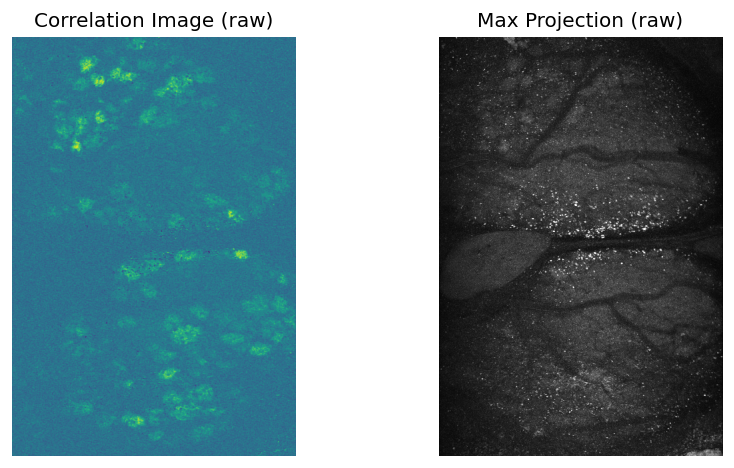

GIF preview disabled (make_gif = False).


In [8]:
# Get frame rate from metadata if available, otherwise use manual setting
fr = get_scanimage_fps(movie_path, default_fr=fr_manual)
print(f"Frame rate: {fr:.2f} Hz")

assert Path(movie_path).exists(), f"movie not found at {movie_path}"

# Toggle this flag to enable/disable GIF preview
make_gif = False

# Load raw movie
movie_orig = cm.load(str(movie_path))
print("Movie shape (T, Y, X):", movie_orig.shape)

# Compute QC images (raw)
max_proj_orig, corr_img_orig = compute_qc_images(movie_orig)

# --- Visualization: correlation and max projection (RAW) ---
figure_summary_A(max_proj_orig, corr_img_orig, [], out_dir / "initial_qc.png")
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1); plt.imshow(corr_img_orig[0]); plt.title('Correlation Image (raw)'); plt.axis('off');
plt.subplot(1, 2, 2); plt.imshow(max_proj_orig[0], cmap='gray'); plt.title('Max Projection (raw)'); plt.axis('off');
plt.tight_layout(); plt.show()

# --- Create & display a short preview GIF of the raw movie ---
if make_gif:
    try:
        T_preview = min(movie_orig.shape[0], int(12 * fr), 300)
        preview = movie_orig[:T_preview].astype(np.float32)
        preview -= np.nanmin(preview)
        denom = np.nanmax(preview)
        if denom > 0: preview /= denom
        preview = (preview * 255).astype("uint8")
        preview_path = out_dir / "raw_preview.gif"
        imageio.mimsave(preview_path, [preview[i] for i in range(preview.shape[0])], duration=1.0/float(fr))
        display(IPyImage(filename=str(preview_path)))
        print("Saved raw movie preview to:", preview_path)
    except Exception as e:
        print(f"Could not create GIF preview. Error: {e}")
else:
    print("GIF preview disabled (make_gif = False).")

### 4) Motion Correction (NoRMCorre)

We use CaImAn's NoRMCorre algorithm to correct for motion artifacts in the movie. This is a crucial step to ensure that fluorescence traces are extracted from consistent ROIs. After correction, we re-compute the QC images to visually confirm the improvement.

In [9]:
# --- Motion Correction ---
mc = run_motion_correction(movie_path, mc_opts)

# Load corrected movie and generate QC images
movie_corr = cm.load(mc.mmap_file)
max_proj_corr, corr_img_corr = compute_qc_images(movie_corr)

# Prepare for memmap (trim if needed)
border_to_0 = 0 if mc.border_nan == "copy" else mc.border_to_0
Yr, dims, T, images, mc_memmap = memmap_movie(mc.mmap_file, border_to_0=border_to_0)

print("Corrected movie memmap:", mc_memmap)
print("Dims:", dims, "Frames:", T)

/Users/mosse/miniforge3/envs/caiman/lib/python3.11/site-packages/caiman/motion_correction.py:3111: RuntimeWarning: Mean of empty slice
  new_temp = np.nanmean(mc, 0)
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.15it/s]


Corrected movie memmap: /Users/mosse/caiman_data/temp/memmap_d1_630_d2_426_d3_1_order_C_frames_240.mmap
Dims: (630, 426) Frames: 240


### 5) CNMF Initialization & Fit

This is the core step where we use Constrained Non-negative Matrix Factorization (CNMF) to identify spatial footprints (ROIs) and their corresponding temporal activity. 

1.  **Start Cluster**: For parallel processing, we initialize a cluster of workers.
2.  **Fit**: The model is fit to the motion-corrected movie data.
3.  **Refit**: A second fit is performed, which often stabilizes and improves the results.
4.  **Visualize**: The identified components are plotted as an overlay on the correlation image.
5.  **Stop Cluster**: The cluster is shut down to free up resources.

[CNMF] FOV: 630x426
[CNMF] CPU cores: 8 -> requesting up to 7 processes
[CNMF] Cluster ready with n_processes=7


/Users/mosse/miniforge3/envs/caiman/lib/python3.11/site-packages/caiman/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/mosse/miniforge3/envs/caiman/lib/python3.11/site-packages/caiman/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/mosse/miniforge3/envs/caiman/lib/python3.11/site-packages/caiman/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this 

[CNMF] Components after fit: 763
[CNMF] Attempting refit


/Users/mosse/miniforge3/envs/caiman/lib/python3.11/site-packages/caiman/source_extraction/cnmf/deconvolution.py:1004: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[lags + np.arange(lags)],


[CNMF] Components after refit: 761


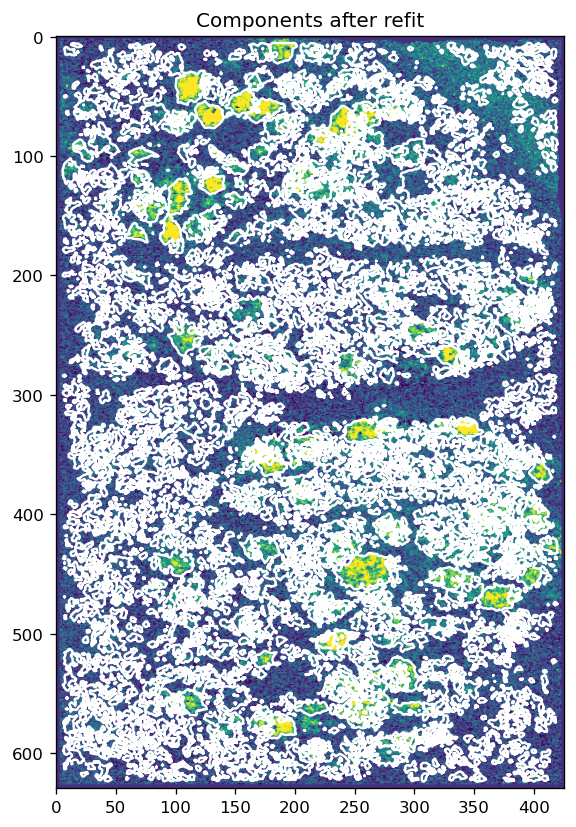

Saved: /Volumes/MossLab/ImagingData/20250822/e2/outputs/components_after_refit.png
[CNMF] Cluster stopped


In [10]:
# --- Toggles ---
use_cluster = True
show_components_after_refit = True
prefer_fit_file = True # Use file-based CNMF for better multiprocessing

# Build params
params = build_cnmf_params(str(movie_path), fr, dxy)
print(f"[CNMF] FOV: {dims[0]}x{dims[1]}")

# --- Start/attach cluster (best-effort) ---
dview, n_processes = None, 1
cluster_started = False
if use_cluster:
    try:
        _cpu = os.cpu_count() or 2
        max_procs_cap = max(1, min(_cpu - 1, 16))
        print(f"[CNMF] CPU cores: {_cpu} -> requesting up to {max_procs_cap} processes")
        c, dview, n_processes = setup_cluster(
            backend="multiprocessing",
            n_processes=max_procs_cap,
            single_thread=False
        )
        cluster_started = True
        print(f"[CNMF] Cluster ready with n_processes={n_processes}")
    except Exception as e:
        print(f"Could not start/connect to cluster; using single-process. Error: {e}")

# --- Fit + Refit ---
memmap_path = mc_memmap if 'mc_memmap' in globals() else None
fit, fit_info = fit_cnmf(
    images=images,
    params=params,
    n_processes=n_processes,
    dview=dview,
    prefer_fit_file=prefer_fit_file,
    memmap_path=memmap_path,
    do_refit=True,
)

# --- Optional visualization: components after refit ---
if show_components_after_refit:
    try:
        est = fit.estimates
        if est is None or est.A is None: raise RuntimeError("No estimates after refit.")
        Cn = corr_img_corr[0] if 'corr_img_corr' in globals() else None
        plt.figure(figsize=(7, 7))
        plot_contours(est.A, Cn=Cn, display_numbers=False)
        plt.title("Components after refit")
        plt.tight_layout()
        out_p = out_dir / "components_after_refit.png"
        plt.savefig(out_p, dpi=200, bbox_inches="tight")
        plt.show()
        print("Saved:", out_p)
    except Exception as e:
        print(f"Could not plot components after refit: {e}")

# --- Stop cluster ---
if use_cluster and cluster_started:
    try:
        stop_server(dview=dview)
        print("[CNMF] Cluster stopped")
    except Exception as e:
        print(f"Note: error while stopping cluster (safe to ignore): {e}")

### 6) Clean Components & QC

The initial CNMF fit often identifies many spurious or poorly-formed components. Here, we apply filters based on morphology (size) and shape (convolution) to discard artifacts and keep only the well-defined ROIs.

We then generate two summary visualizations:
1.  **Figure A**: A side-by-side plot of the correlation image and max projection, with the final, cleaned ROI contours overlaid.
2.  **Overlay Figure**: A detailed view showing all component classes (kept, small, large, convoluted) overlaid on the max projection image, which helps in diagnosing and tuning the cleaning parameters.

In [11]:
# --- Clean & QC ---
clean = clean_components(
    fit, images,
    threshold_percentile=threshold_percentile,
    min_pixels=min_pixels,
    max_pixels=max_pixels,
    convolution_threshold=convolution_threshold
)

# --- Unpack results ---
cleaned_A_list = clean["cleaned_A_list"]
valid_contours = clean["valid_contours"]
kept_indices = clean["kept_indices"]

# 3D stack of cleaned components (for figure panels)
d1, d2 = fit.dims
if len(cleaned_A_list):
    cleaned_A_3d = np.stack(cleaned_A_list, axis=-1).reshape((d1, d2, len(cleaned_A_list)))
else:
    cleaned_A_3d = np.empty((d1, d2, 0))

# --- QC overlay figure (A): correlation image + max projection with contours ---
figure_summary_A(max_proj_corr, corr_img_corr, valid_contours, summary_fig_A)
print("Saved summary figure A:", summary_fig_A)

Saved summary figure A: /Volumes/MossLab/ImagingData/20250822/e2/outputs/summary_corr_max_overlays.png


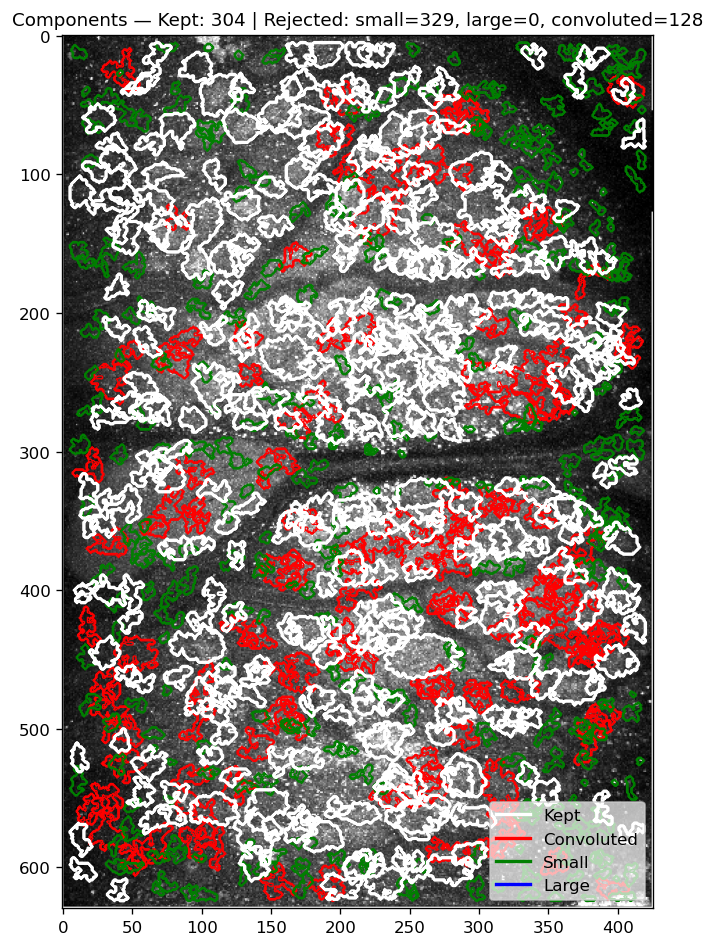

Saved: /Volumes/MossLab/ImagingData/20250822/e2/outputs/summary_overlay_all_classes.png


In [12]:
# --- Summary overlay figure on max projection with colored classes ---

# Choose a background image
try:
    bg = max_proj_corr[0]
except (TypeError, IndexError):
    bg = images.max(axis=0)

fig, ax = plt.subplots(figsize=(8, 8))
vmin, vmax = np.percentile(bg, (1, 99))
ax.imshow(bg, cmap="gray", vmin=vmin, vmax=vmax)

def _draw_edges(edge_list, color, lw, label):
    for i, edge in enumerate(edge_list):
        try:
            # Only add label to the first contour to avoid legend clutter
            contour_label = label if i == 0 else None
            ax.contour(edge.astype(float), levels=[0.5], colors=color, linewidths=lw)
        except Exception:
            pass # Ignore if a contour can't be drawn
    # Create a proxy artist for the legend
    return plt.Line2D([0], [0], color=color, lw=2, label=label)

# Plot rejected first (underlay), then kept (overlay)
h_conv = _draw_edges(clean['convoluted_contours'], "red", 0.8, "Convoluted")
h_small = _draw_edges(clean['small_contours'], "green", 0.8, "Small")
h_large = _draw_edges(clean['large_contours'], "blue", 0.8, "Large")
h_kept = _draw_edges(clean['valid_contours'], "white", 1.2, "Kept")

# Title with counts
ax.set_title(
    f"Components — Kept: {len(clean['valid_contours'])} | "
    f"Rejected: small={len(clean['small_contours'])}, large={len(clean['large_contours'])}, convoluted={len(clean['convoluted_contours'])}",
    fontsize=11
)

# Legend
ax.legend(handles=[h_kept, h_conv, h_small, h_large], loc="lower right", frameon=True, framealpha=0.7)

plt.tight_layout()
out_overlay = out_dir / "summary_overlay_all_classes.png"
plt.savefig(out_overlay, dpi=250, bbox_inches="tight")
plt.show()
print("Saved:", out_overlay)

### 7) Extract Fluorescence Traces & Build DataFrames

Using the cleaned spatial footprints, we now extract the final fluorescence traces from the motion-corrected movie. We assemble this data into several convenient pandas DataFrame formats:

*   **`df_pixels`**: A long-format table with detailed information for every pixel in every kept ROI, including its coordinates and weight.
*   **`df_traces_wide`**: A wide-format table where each column represents the trace (F, Z-score, or dF/F) for a single ROI, indexed by time.
*   **`df_traces_long`**: A tidy, long-format table suitable for statistical analysis and plotting, with columns for time, ROI ID, measure type (F, Z, dF/F), and value.

In [19]:
# Build all outputs in one call (valid ROIs only)
df_pixels, df_traces_wide, df_traces_long = build_roi_tables_unified(
    fit=fit,
    images=images,
    fr=fr,
    clean=clean
)

# Inspect the resulting dataframes
print("--- df_pixels ---")
display(df_pixels.head())
print("\n--- df_traces_wide ---")
display(df_traces_wide.head())
print("\n--- df_traces_long ---")
display(df_traces_long.head())

--- df_pixels ---


,ROI,pixel_idx,y,x,weight_raw,weight_norm
0,3,33410,20,53,0.015832,0.001288
1,3,33411,21,53,0.010680,0.000869
2,3,34039,19,54,0.010680,0.000869
3,3,34040,20,54,0.046716,0.003801
4,3,34041,21,54,0.046716,0.003801



--- df_traces_wide ---


,time_s,ROI_3_F,ROI_3_Z,ROI_3_dFF,ROI_4_F,ROI_4_Z,ROI_4_dFF,ROI_6_F,ROI_6_Z,ROI_6_dFF,...,ROI_756_dFF,ROI_757_F,ROI_757_Z,ROI_757_dFF,ROI_759_F,ROI_759_Z,ROI_759_dFF,ROI_760_F,ROI_760_Z,ROI_760_dFF
0,0.000000,2869.777171,0.215211,0.054513,2928.343990,1.694503,0.044098,2929.489479,2.485505,0.038215,...,0.130665,4864.381527,3.032948,0.022307,4123.330653,1.659491,0.093108,5767.492841,2.489060,0.321282
1,0.041776,2905.445002,2.082933,0.066372,2851.851988,1.419248,0.016441,2966.835264,2.366934,0.058730,...,0.139703,5172.503317,1.359945,0.087161,4296.600032,2.843903,0.137515,5902.245410,3.518203,0.382708
2,0.083552,3096.622292,0.648598,0.152020,2916.374551,1.346658,0.041168,3194.534386,2.674870,0.139299,...,0.179387,5118.228798,2.991416,0.084498,4283.528959,2.550548,0.145536,5631.836074,3.763258,0.321739
3,0.125328,2847.528445,1.797714,0.062952,2966.251046,1.459846,0.061726,3108.717371,2.182620,0.108027,...,0.164668,4972.612126,3.372440,0.057138,4176.640785,2.117532,0.130915,5208.212896,2.671660,0.254175
4,0.167104,2895.294302,1.036174,0.080555,3055.406869,0.871256,0.100390,3119.544723,1.311278,0.111218,...,0.172932,5056.226579,3.475964,0.091971,4089.720488,1.849966,0.109522,5041.452625,2.101978,0.217977



--- df_traces_long ---


,time_s,ROI,measure,value
0,0.000000,3,F,2869.777171
1,0.041776,3,F,2905.445002
2,0.083552,3,F,3096.622292
3,0.125328,3,F,2847.528445
4,0.167104,3,F,2895.294302


### 8) Summary Figure B — ROI Panels

This step generates a multi-page PDF where each page displays a set of ROIs. For each ROI, it shows its spatial footprint on the left and its corresponding fluorescence trace on the right. This is an essential output for visually inspecting the quality of individual components.

In [14]:
figure_panels_from_tables(
    df_pixels=df_pixels,
    df_traces_wide=df_traces_wide,
    pdf_path=summary_fig_B_pdf,
    dims=(d1, d2),
    per_page=roi_panels_per_page,
    corr_image=corr_img_corr[0] if 'corr_img_corr' in globals() else None, # optional background
)
print("Saved summary figure B (PDF panels):", summary_fig_B_pdf)

Saved summary figure B (PDF panels): /Volumes/MossLab/ImagingData/20250822/e2/outputs/roi_panels.pdf


### 9) Save Unified HDF5 Output

Finally, we save all the important data into a single, portable HDF5 file. This file contains:

-   **/metadata**: Key parameters used for the analysis (frame rate, pixel size, thresholds, etc.) stored as attributes.
-   **/roi_info**: A table containing the pixel coordinates and weights for every kept ROI (from `df_pixels`).
-   **/traces**: A group containing the fluorescence data as numerical arrays:
    -   `raw_F`: Raw fluorescence traces.
    -   `dFF`: dF/F traces.
    -   `z_score`: Z-scored traces.
-   **/kept_indices**: An array of the original component indices that were kept after cleaning.

In [17]:
# --- Extract trace arrays from the wide dataframe ---
# This is more efficient for HDF5 storage than saving the full dataframe
F_traces, Z_traces, dFF_traces = None, None, None
if not df_traces_wide.empty:
    roi_ids = sorted([int(c.split('_')[1]) for c in df_traces_wide.columns if c.startswith('ROI_') and c.endswith('_F')])
    F_traces = df_traces_wide[[f'ROI_{roi}_F' for roi in roi_ids]].to_numpy().T
    Z_traces = df_traces_wide[[f'ROI_{roi}_Z' for roi in roi_ids]].to_numpy().T
    dFF_traces = df_traces_wide[[f'ROI_{roi}_dFF' for roi in roi_ids]].to_numpy().T

# --- Minimal metadata for reproducibility ---
meta = dict(
    source_movie=str(movie_path.resolve()),
    created_utc=datetime.utcnow().isoformat() + "Z",
    fr=fr,
    dxy=dxy,
    decay_time=decay_time,
    K_init=int(K),
    thresholds=dict(
        threshold_percentile=float(threshold_percentile),
        min_pixels=float(min_pixels),
        max_pixels=float(max_pixels),
        convolution_threshold=float(convolution_threshold),
    ),
    shapes=dict(
        movie_T=int(df_traces_wide.shape[0]),
        n_rois=int(cleaned_A_3d.shape[2] if cleaned_A_3d.size else 0),
    )
)

# --- Save to HDF5 ---
if F_traces is not None:
    save_hdf5_output(
        output_path=export_hdf5,
        df_pixels=df_pixels,
        F_traces=F_traces,
        Z_traces=Z_traces,
        dFF_traces=dFF_traces,
        kept_indices=kept_indices,
        metadata_dict=meta
    )
    print("Saved unified output to:", export_hdf5)
else:
    print("No ROIs were kept, so no HDF5 file was saved.")

Saved unified output to: /Volumes/MossLab/ImagingData/20250822/e2/outputs/caiman_analysis_results.hdf5


### 10) Notes, Tuning & Troubleshooting

*   **Tuning footprint thresholds**: `threshold_percentile`, `min_pixels`, `max_pixels`, and `convolution_threshold` are the main levers for cleaning components. Use the colored overlay figure from Step 6 to guide your adjustments.

*   **Motion correction**: If edge artifacts appear after motion correction, you may need to adjust the `max_shifts` and `overlaps` parameters, which are derived from `w10`.

*   **CNMF parameters**: If you are missing ROIs, try increasing `K` (components per patch) or adjusting `gSig` to better match your expected ROI size.

*   **Performance**: For multicore processing, ensure `use_cluster` is set to `True` in Step 5. This can provide a significant speedup on machines with multiple CPU cores.

*   **dF/F**: The pipeline extracts raw `F`. The dF/F calculation uses a rolling percentile for baseline estimation. You can modify the `rolling_percentile` function or replace it with your preferred baseline correction method.

### 11) Final Cleanup (Optional)

This final step cleans up the temporary files created by CaImAn during the analysis. When you run motion correction and CNMF on memory-mapped files, CaImAn saves intermediate versions (with a `.mmap` extension) in a default temporary directory, which is typically `~/caiman_data/temp/`.

These files can be quite large, and it is good practice to remove them once the analysis is complete and the final results have been saved to your HDF5 file.

Running the code cell below will safely:
1.  Locate the default CaImAn temporary directory.
2.  List all files within it.
3.  Delete each file, printing a confirmation.

This is a safe and recommended final step to free up disk space.

In [ ]:
# %% Cell for Final Cleanup of CaImAn Temporary Files
from pathlib import Path

# CaImAn's default temporary directory is typically located in the user's home folder.
caiman_temp_dir = Path.home() / 'caiman_data' / 'temp'

print(f"--- Starting Cleanup of CaImAn Temporary Files ---")
print(f"Target directory: {caiman_temp_dir}")

# Check if the directory exists before trying to clean it.
if caiman_temp_dir.is_dir():
    try:
        # List all files in the directory.
        temp_files = [f for f in caiman_temp_dir.iterdir() if f.is_file()]
        
        if not temp_files:
            print("Status: Temporary directory is empty. No files to delete.")
        else:
            print("Found the following files to delete:")
            num_deleted = 0
            for f_path in temp_files:
                try:
                    f_path.unlink() # This deletes the file.
                    print(f"  - Deleted: {f_path.name}")
                    num_deleted += 1
                except OSError as e:
                    print(f"  - ERROR: Could not delete {f_path.name}. Reason: {e}")
            
            print(f"\nCleanup complete. Successfully deleted {num_deleted} file(s).")

    except Exception as e:
        print(f"An unexpected error occurred during cleanup: {e}")
else:
    print("Status: Temporary directory not found. No cleanup was necessary.")